### IMPORTATION OF LIBRARIES

In [3]:
"""import libraries numpy for numerical operations, pandas for working with dataframes,
tensorflow for deep learning, matplotlib for visualizations, cv2 for some visualizations as well
"""
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import classification_report

### LOAD DATASETS

In [4]:
#load datasets i.e the training test and validation set
train_directory = r'C:\Users\D2ndjim\Mines\SSWM_project\train'
validation_directory = r'C:\Users\D2ndjim\Mines\SSWM_project\val'
test_data = r'C:\Users\D2ndjim\Mines\SSWM_project\test'

In [5]:
#pre-process image data with keras which also loads the images from a file path
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [6]:
CLASS_MODE = "categorical"  # defines how the labels are represented in the data 
TARGET_SIZE = (256,256)  # A tuple specifying the height and width of the image
BATCH_SIZE = 16  #The batch size of our data.

### PRE-PROCESS DATA

In [7]:
#creates a DirectoryIterator that loads images from specified directory as 256 by 256 pixel color images in batches of 32:
train_directory = r'C:\Users\D2ndjim\Mines\SSWM_project\train'
training_iterator = img_generator.flow_from_directory(train_directory,class_mode=CLASS_MODE,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,shuffle=True,seed=1)

                                                    

Found 1287 images belonging to 6 classes.


In [8]:
validation_iterator = img_generator.flow_from_directory(validation_directory,class_mode=CLASS_MODE,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,shuffle=True,seed=1)                                              

Found 389 images belonging to 6 classes.


In [9]:
#iterate over the training batches to view the dimensions
sample_batch_input,sample_batch_labels  = training_iterator.next()
 
print(sample_batch_input.shape,sample_batch_labels.shape)

(16, 256, 256, 3) (16, 6)


### VISUALIZE DATA THROUGH ITERATION

In [10]:
#reference- the function below was gotten from https://www.kaggle.com/ilyapozdnyakov/computer-vision-plants-cnn-visualisation
x,y = next(training_iterator) #uses ".next" to iterate through the images
from mpl_toolkits.axes_grid1 import ImageGrid #imports imagegrid to help visualize the iterated images


#functiion to iterate through train data for imagegrid visualization
def show_grid(image_list, nrows, ncols, label_list=None, show_labels=False, figsize=(10,10)):
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(nrows, ncols),  
                     axes_pad=0.2, 
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis('off')

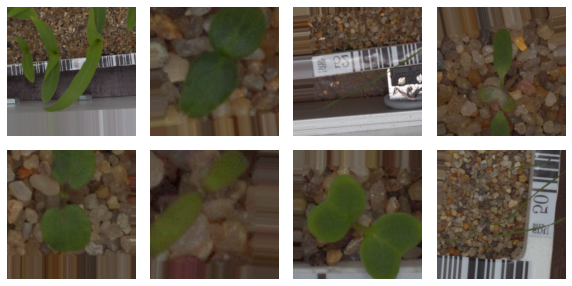

In [11]:
show_grid(x,2,4,show_labels=True,figsize=(10,10))

In [12]:
training_iterator.class_indices

{'blackgrass': 0,
 'charlock': 1,
 'cleavers': 2,
 'fat hen': 3,
 'maize': 4,
 'wheat': 5}

### MODEL BUILDING

In [13]:
#the model used is a sequential model using
#four(4) convolutional layers are added to the data
#Adding layers that pool local information to reduce the dimensionality of intermediate convolutional outputs using MaxPool@D
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(256,256,3,)))
classifier.add(tf.keras.layers.Conv2D(30, kernel_size=(3,3), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
classifier.add(tf.keras.layers.BatchNormalization())
classifier.add(tf.keras.layers.Conv2D(30, kernel_size=(3,3), strides = (1,1), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
classifier.add(tf.keras.layers.BatchNormalization())
classifier.add(tf.keras.layers.Conv2D(60, kernel_size=(3,3), strides = (1,1), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
classifier.add(tf.keras.layers.BatchNormalization())
classifier.add(tf.keras.layers.Conv2D(60, kernel_size=(3,3), strides = (1,1), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
classifier.add(tf.keras.layers.GlobalMaxPool2D())
classifier.add(tf.keras.layers.Flatten())
classifier.add(tf.keras.layers.Dense(60, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.2))
classifier.add(tf.keras.layers.Dense(30, activation='relu'))
classifier.add(tf.keras.layers.BatchNormalization())

#output layer representing the 6 predicted classes
classifier.add(tf.keras.layers.Dense(6, activation='softmax')) 


In [14]:
#compiles the model with optimizer(Adam) and loss of categorical_crossentropy and accuracy as metric for model.
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])


In [15]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 30)      840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 30)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 30)      120       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 30)      8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 30)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 30)        120       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 60)        1

In [16]:
history = classifier.fit(training_iterator,
          epochs=15, # Increase number of epochs if you have sufficient hardware
          steps_per_epoch= 1287//BATCH_SIZE,  # Number of train images // batch_size
          validation_data=validation_iterator,
          validation_steps = 389//BATCH_SIZE, # Number of val images // batch_size
          verbose = 1
)

Epoch 1/15
80/80 [==============================] - 216s 3s/step - loss: 1.9422 - categorical_accuracy: 0.1987 - auc: 0.5543 - val_loss: 2.0869 - val_categorical_accuracy: 0.2500 - val_auc: 0.5431
Epoch 2/15
80/80 [==============================] - 193s 2s/step - loss: 1.4359 - categorical_accuracy: 0.4035 - auc: 0.7816 - val_loss: 2.9019 - val_categorical_accuracy: 0.1484 - val_auc: 0.5044
Epoch 3/15
80/80 [==============================] - 183s 2s/step - loss: 1.5471 - categorical_accuracy: 0.3648 - auc: 0.7472 - val_loss: 2.1785 - val_categorical_accuracy: 0.1510 - val_auc: 0.5214
Epoch 4/15
80/80 [==============================] - 185s 2s/step - loss: 1.4424 - categorical_accuracy: 0.3928 - auc: 0.7820 - val_loss: 1.6382 - val_categorical_accuracy: 0.2630 - val_auc: 0.6943
Epoch 5/15
80/80 [==============================] - 179s 2s/step - loss: 1.1945 - categorical_accuracy: 0.5136 - auc: 0.8540 - val_loss: 2.5122 - val_categorical_accuracy: 0.3151 - val_auc: 0.6102
Epoch 6/15
80/8

### PREDICTION USING TEST SET

In [17]:
test_iterator = img_generator.flow_from_directory(test_data,class_mode=CLASS_MODE,target_size=TARGET_SIZE,shuffle=True,seed=1)

Found 412 images belonging to 6 classes.


In [18]:
#this shows the accuracy of the model in classifying the validation data
score = classifier.evaluate(validation_iterator)
print(score[-1])

25/25 [==============================] - 23s 885ms/step - loss: 1.0324 - categorical_accuracy: 0.6324 - auc: 0.9165
0.9164583086967468


In [19]:
#this shows the accuracy of the model in classifying the test data
test_score = classifier.evaluate(test_iterator)
print(test_score[-1])

13/13 [==============================] - 32s 3s/step - loss: 1.0800 - categorical_accuracy: 0.6602 - auc: 0.9095
0.9095262289047241


In [20]:
prediction = classifier.predict(test_iterator)

In [21]:
CATEGORIES = ['blackgrass', 'charlock', 'cleavers', 'fat hen', 'maize', 'wheat']

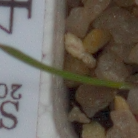

In [24]:
from IPython.display import Image
weed = Image(filename='blackgrass.png', width = 256, height = 256)
weed

In [26]:
#first prediction made in the test is a blackgrass 
print(CATEGORIES[int(prediction[0][0])])

blackgrass
